In [104]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px 
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from scipy.optimize import minimize
# from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from IPython.display import display, HTML
import io
import random
from scipy.stats import pointbiserialr
from math import sqrt

In [128]:
train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'


train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
test_df_o = pd.read_csv(test_data_path)


In [129]:
test_df_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   warehouse               397 non-null    object
 1   date                    397 non-null    object
 2   holiday_name            17 non-null     object
 3   holiday                 397 non-null    int64 
 4   shops_closed            397 non-null    int64 
 5   winter_school_holidays  397 non-null    int64 
 6   school_holidays         397 non-null    int64 
 7   id                      397 non-null    object
dtypes: int64(4), object(4)
memory usage: 24.9+ KB


In [130]:
train_df.isnull().sum()

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shutdown                     0
mini_shutdown                0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
blackout                     0
mov_change                   0
frankfurt_shutdown           0
precipitation              270
snow                       270
user_activity_1              0
user_activity_2              0
id                           0
dtype: int64

In [131]:
#Dealing with continous variables
train_df.describe().round(2)

,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2
count,7340.00,7340.00,7340.00,7340.00,7340.00,7340.00,7340.00,7340.00,7340.00,7340.00,7070.00,7070.00,7340.00,7340.00
mean,5535.44,0.03,0.00,0.00,0.01,0.03,0.01,0.00,0.22,0.00,1.62,0.29,1633.55,23477.03
std,2182.68,0.16,0.01,0.02,0.10,0.17,0.08,0.03,0.41,0.02,4.54,1.55,784.17,8934.85
min,790.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,482.00,1797.00
25%,4434.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,945.00,18509.00
50%,5370.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1349.00,22267.00
75%,7009.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,2308.00,30028.75
max,18139.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,80.00,19.84,3437.00,45769.00


In [132]:
#Drop unnecessary columns (Columns which are present in the test data set and hence cannot be used to predict or train)
cols_to_drop = ['blackout','shutdown', 'mini_shutdown', 'mov_change', 'frankfurt_shutdown', 'precipitation', 'snow', 'user_activity_1', 'user_activity_2']
train_df.drop(cols_to_drop, axis=1, inplace=True)

In [133]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7340 non-null   object 
 1   date                    7340 non-null   object 
 2   orders                  7340 non-null   float64
 3   holiday_name            218 non-null    object 
 4   holiday                 7340 non-null   int64  
 5   shops_closed            7340 non-null   int64  
 6   winter_school_holidays  7340 non-null   int64  
 7   school_holidays         7340 non-null   int64  
 8   id                      7340 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 516.2+ KB


*Initial Data Visualizations and studies*

C:\Users\Prachet.balaji\AppData\Local\Temp\ipykernel_11052\689860213.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  p = sns.countplot(y=col, data=df, palette='Set2', edgecolor='white', linewidth=2, ax=axs[i], order=df[col].value_counts().index)
C:\Users\Prachet.balaji\AppData\Local\Temp\ipykernel_11052\689860213.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  p = sns.countplot(y=col, data=df, palette='Set2', edgecolor='white', linewidth=2, ax=axs[i], order=df[col].value_counts().index)
C:\Users\Prachet.balaji\AppData\Local\Temp\ipykernel_11052\689860213.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and se

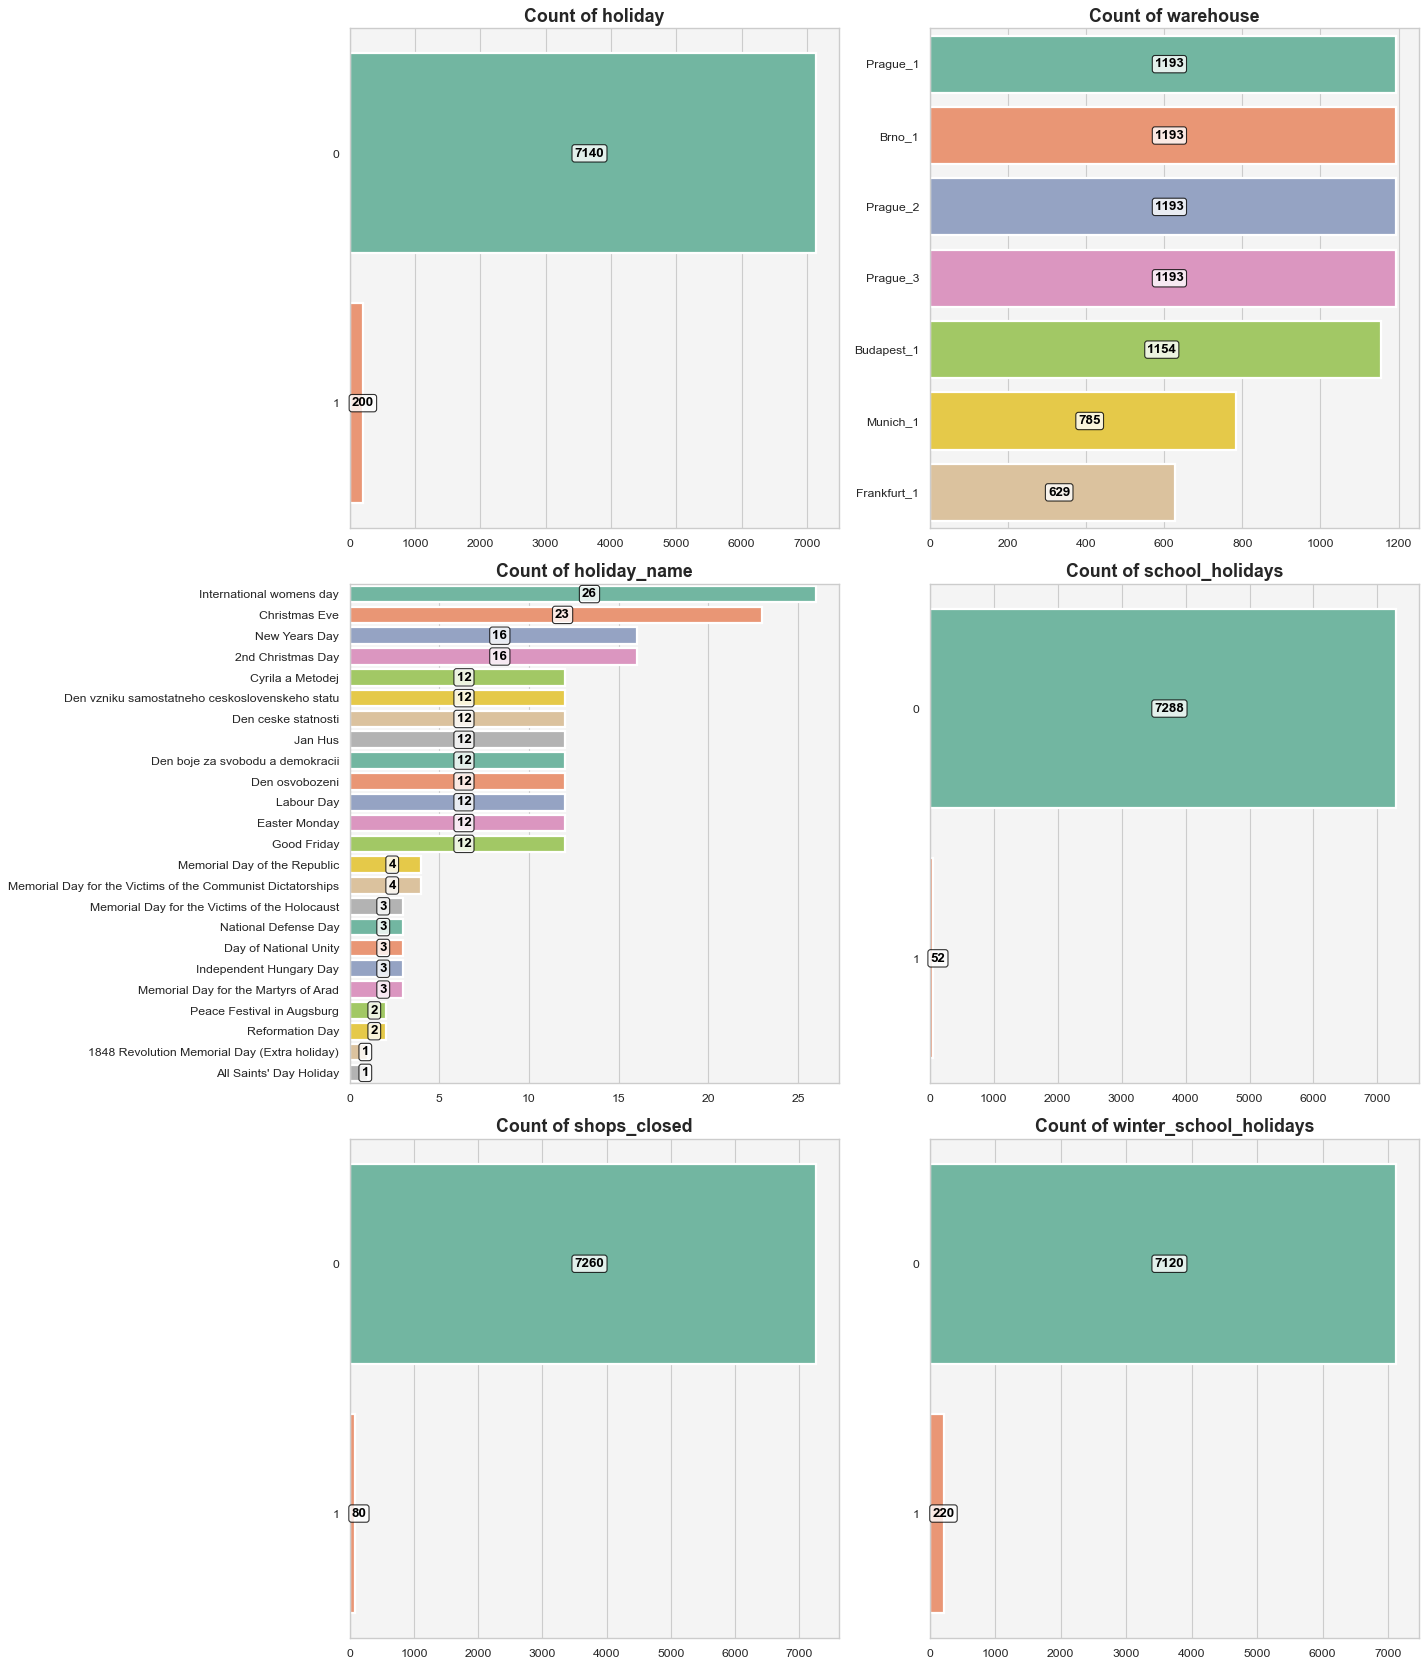

In [134]:
df = train_df
def plot_bar_with_counts(df):
    background_color = '#f4f4f4'
    sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})
    
    # Define columns for bar plots
    bar_columns = ['holiday', 'warehouse', 'holiday_name', 'school_holidays', 'shops_closed','winter_school_holidays']
    
    num_plots = len(bar_columns)
    num_rows = (num_plots + 1) // 2  # Adjust number of rows for subplot layout
    num_cols = 2  # Set number of columns for subplot layout
    
    # Increase the size of the figure
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 7 * num_rows), dpi=80)
    axs = axs.flatten()
    
    for i, col in enumerate(bar_columns):
        p = sns.countplot(y=col, data=df, palette='Set2', edgecolor='white', linewidth=2, ax=axs[i], order=df[col].value_counts().index)
        p.set_title(f'Count of {col}', fontsize=16, weight='bold')  # Increase title font size
        p.set_xlabel('')
        p.set_ylabel('')
        
        # Add counts inside bars
        for container in p.containers:
            p.bar_label(container, label_type='center', color="black", fontsize=12, weight='bold', padding=6,
                        bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 1, "alpha": 0.8})
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

plot_bar_with_counts(df)

Feature Engineering

In [135]:
#Encode the two categorical Columns using label encoders
label_encoders = {}
for col in ['warehouse', 'holiday_name']:
    label_encoders[col] = LabelEncoder()
    train_df[col] = label_encoders[col].fit_transform(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])

In [136]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7340 non-null   int32  
 1   date                    7340 non-null   object 
 2   orders                  7340 non-null   float64
 3   holiday_name            7340 non-null   int32  
 4   holiday                 7340 non-null   int64  
 5   shops_closed            7340 non-null   int64  
 6   winter_school_holidays  7340 non-null   int64  
 7   school_holidays         7340 non-null   int64  
 8   id                      7340 non-null   object 
dtypes: float64(1), int32(2), int64(4), object(2)
memory usage: 458.9+ KB


In [137]:
#Date is still a object, must convert to int/float
# Feature engineering function
def add_date_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df.drop('date', axis=1, inplace=True)
    return df

# Apply feature engineering to both train and test data
train_df = add_date_features(train_df)
test_df = add_date_features(test_df)

In [138]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7340 non-null   int32  
 1   orders                  7340 non-null   float64
 2   holiday_name            7340 non-null   int32  
 3   holiday                 7340 non-null   int64  
 4   shops_closed            7340 non-null   int64  
 5   winter_school_holidays  7340 non-null   int64  
 6   school_holidays         7340 non-null   int64  
 7   id                      7340 non-null   object 
 8   year                    7340 non-null   int32  
 9   month                   7340 non-null   int32  
 10  day                     7340 non-null   int32  
 11  dayofweek               7340 non-null   int32  
 12  is_weekend              7340 non-null   int32  
dtypes: float64(1), int32(7), int64(4), object(1)
memory usage: 544.9+ KB


In [139]:
test_df.info()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   warehouse               397 non-null    int32 
 1   holiday_name            397 non-null    int32 
 2   holiday                 397 non-null    int64 
 3   shops_closed            397 non-null    int64 
 4   winter_school_holidays  397 non-null    int64 
 5   school_holidays         397 non-null    int64 
 6   id                      397 non-null    object
 7   year                    397 non-null    int32 
 8   month                   397 non-null    int32 
 9   day                     397 non-null    int32 
 10  dayofweek               397 non-null    int32 
 11  is_weekend              397 non-null    int32 
dtypes: int32(7), int64(4), object(1)
memory usage: 26.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 13 columns):

In [140]:
# Ensure all features are numeric
def ensure_numeric(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = LabelEncoder().fit_transform(df[col])
    return df

train_df = ensure_numeric(train_df)
test_df = ensure_numeric(test_df)

<Axes: >

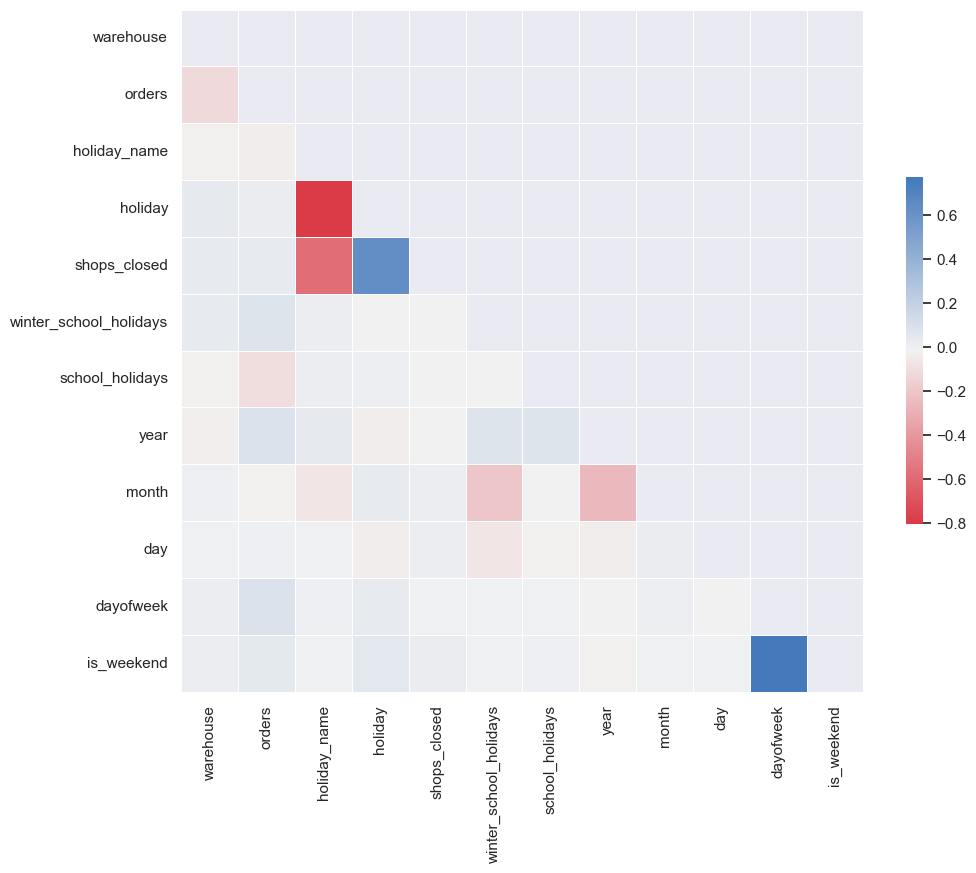

In [141]:
train_df_corr = train_df.drop('id',axis=1)
# use the pandas .corr() function to compute pairwise correlations for the dataframe
corr = train_df_corr.corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'dark')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [142]:
#Feature Selection using correlation 

features = train_df.columns.tolist()
features.remove('orders')

features

X = train_df.drop('orders', axis = 1)
y = train_df['orders']

In [120]:
def getMerit(subset, label):
    k = len(subset)

    # average feature-class correlation
    rcf_all = []
    for feature in subset:
        coeff = pointbiserialr(train_df[label], train_df[feature] )
        rcf_all.append( abs( coeff.correlation ) )
    rcf = np.mean( rcf_all )

    # average feature-feature correlation
    corr = train_df[subset].corr()
    corr.values[np.tril_indices_from(corr.values)] = np.nan
    corr = abs(corr)
    rff = corr.unstack().mean()

    return (k * rcf) / sqrt(k + k * (k-1) * rff)

In [121]:
best_value = -1
best_feature = ''
for feature in features:
    coeff = pointbiserialr(y, X[feature] )
    abs_coeff = abs( coeff.correlation )
    if abs_coeff > best_value:
        best_value = abs_coeff
        best_feature = feature

print("Feature %s with merit %.4f"%(best_feature, best_value))


Feature warehouse with merit 0.1202


In [98]:
class PriorityQueue:
    def  __init__(self):
        self.queue = []

    def isEmpty(self):
        return len(self.queue) == 0
    
    def push(self, item, priority):
        """
        item already in priority queue with smaller priority:
        -> update its priority
        item already in priority queue with higher priority:
        -> do nothing
        if item not in priority queue:
        -> push it
        """
        for index, (i, p) in enumerate(self.queue):
            if (set(i) == set(item)):
                if (p >= priority):
                    break
                del self.queue[index]
                self.queue.append( (item, priority) )
                break
        else:
            self.queue.append( (item, priority) )
        
    def pop(self):
        # return item with highest priority and remove it from queue
        max_idx = 0
        for index, (i, p) in enumerate(self.queue):
            if (self.queue[max_idx][1] < p):
                max_idx = index
        (item, priority) = self.queue[max_idx]
        del self.queue[max_idx]
        return (item, priority)

In [68]:
# initialize queue
queue = PriorityQueue()

# push first tuple (subset, merit)
queue.push([best_feature], best_value)

# list for visited nodes
visited = []

# counter for backtracks
n_backtrack = 0

# limit of backtracks
max_backtrack = 100

In [69]:

best_value = float('-inf')  # Initialize with a very low value
best_subset = ['warehouse']
n_backtrack = 0
max_backtrack = 10000  # Set to your desired max backtracks


visited = set()
queue = PriorityQueue()

# Initialize the queue with the best feature (assuming best_feature is already determined)
initial_subset = best_subset
initial_merit = getMerit(initial_subset, 'orders')
queue.push(initial_subset, initial_merit)
visited.add(frozenset(initial_subset))

# Repeat until queue is empty or the maximum number of backtracks is reached
while not queue.isEmpty():
    # Get element of queue with highest merit
    subset, priority = queue.pop()
    
    # Check whether the priority of this subset is higher than the current best subset
    if priority < best_value:
        n_backtrack += 1
    else:
        best_value = priority
        best_subset = subset

    # Goal condition
    if n_backtrack == max_backtrack:
        break
    
    # Iterate through all features and check if one can increase the merit
    for feature in features:
        if feature not in subset:
            temp_subset = subset + [feature]
            temp_frozenset = frozenset(temp_subset)
        
            # Check if this subset has already been evaluated
            if temp_frozenset not in visited:
                # Mark it as visited
                visited.add(temp_frozenset)
            
                # Compute merit
                merit = getMerit(temp_subset, 'orders')
                print(merit)
                # Push it to the queue
                queue.push(temp_subset, merit)

# Return the best subset based on the best merit
print("Best Subset:", best_subset)
print("Best Merit Value:", best_value)



0.10736455524888697
0.09596753149813497
0.107878605507664
0.1372498854718769
0.15759167641633554
0.11435135722324843
0.1436594943838248
0.10280546365018486
0.08682941402377234
0.14535450604488415
0.11714783402579144
0.14650760528784976
0.13751356141456617
0.14708835990701943
0.17063266166490926
0.14808121989676207
0.17260987988421445
0.14304241505632834
0.1297141735422099
0.17784006523657508
0.15506552057530693
0.1694841579356913
0.16038984360220493
0.16975656594685945
0.19023956847596113
0.1696528806801824
0.19150456447481817
0.16631632433523466
0.15455145000593137
0.15076983774749014
0.18441158336291505
0.17664343336037647
0.18535672916517223
0.2011391266522896
0.18367364783273893
0.17477091781739018
0.17154496609995554
0.16876088488885843
0.19561409066606836
0.18847643332220418
0.1962830408758718
0.19537873126080568
0.18238371394249792
0.1826256959492128
0.18208195672471417
0.1802919394413452
0.17339733751698175
0.19405449567325236
0.1812271246603709
0.1808105257905887
0.18131740626

In [70]:
# X = X[best_subset]
# X

In [122]:


# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models and their hyperparameters
models = {
    "CatBoost": {
        "model": CatBoostRegressor(),
        "params": {
            'iterations': [100, 200, 300,400,500],
            'depth': [6, 8, 10],
            'learning_rate': [0.05, 0.1, 0.2]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2]
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(),
        "params": {
            'n_estimators': [100, 200, 300],
            'num_leaves': [31, 50, 70],
            'learning_rate': [0.05, 0.1, 0.2]
        }
    },
    "GBR": {
        "model": GradientBoostingRegressor(),
        "params": {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2]
        }
    }
}

best_model = None
best_mape = float("inf")
best_r2 = -float("inf")
best_model_name = ""

for model_name, model_info in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=model_info["model"], param_grid=model_info["params"], cv=3, scoring='neg_mean_absolute_percentage_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_
    
    # Get best parameters
    best_params = grid_search.best_params_
    print(f"Best parameters for {model_name}: {best_params}")
    
    # Evaluate on validation set
    y_pred = best_estimator.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)
    print(f"{model_name} Validation MAPE: {mape}, R^2 Score: {r2}")
    
    if mape < best_mape:
        best_mape = mape
        best_r2 = r2
        best_model = best_estimator
        best_model_name = model_name

print(f"Best model: {best_model_name}")
print(f"Best validation MAPE: {best_mape}")
print(f"Corresponding R^2 Score: {best_r2}")



Training CatBoost...
Fitting 3 folds for each of 45 candidates, totalling 135 fits
0:	learn: 1807.5138656	total: 6.71ms	remaining: 3.35s
1:	learn: 1530.2902515	total: 11.8ms	remaining: 2.94s
2:	learn: 1307.4657010	total: 17.5ms	remaining: 2.89s
3:	learn: 1133.0973736	total: 22.5ms	remaining: 2.79s
4:	learn: 994.3247129	total: 27.8ms	remaining: 2.75s
5:	learn: 882.5403720	total: 32.4ms	remaining: 2.67s
6:	learn: 805.6529668	total: 37ms	remaining: 2.61s
7:	learn: 746.7022461	total: 41.5ms	remaining: 2.55s
8:	learn: 695.1690885	total: 46.3ms	remaining: 2.52s
9:	learn: 650.0012668	total: 50.5ms	remaining: 2.47s
10:	learn: 608.5349881	total: 54.6ms	remaining: 2.43s
11:	learn: 582.3995656	total: 59.3ms	remaining: 2.41s
12:	learn: 560.8924122	total: 63.4ms	remaining: 2.37s
13:	learn: 540.8844302	total: 67.5ms	remaining: 2.34s
14:	learn: 518.8462688	total: 71.6ms	remaining: 2.31s
15:	learn: 503.2189011	total: 76.2ms	remaining: 2.31s
16:	learn: 488.6948209	total: 80.4ms	remaining: 2.28s
17:	lea

In [123]:
# After training and evaluating the models, find the best model and its performance
print(f"Best model: {best_model_name}")
print(f"Best validation MAPE: {best_mape}")
print(f"Corresponding R^2 Score: {best_r2}")

# Assuming you want to save these results for further analysis or reporting
# You can save the results in a CSV file or any other desired format
results = {
    "Best Model": [best_model_name],
    "Best MAPE": [best_mape],
    "Best R^2 Score": [best_r2]
}

results_df = pd.DataFrame(results)
results_df.to_csv('/best_model_sample_sol.csv', index=False)

Best model: CatBoost
Best validation MAPE: 0.03515652997376669
Corresponding R^2 Score: 0.9839966890211342


In [124]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   warehouse               7340 non-null   int32
 1   holiday_name            7340 non-null   int32
 2   holiday                 7340 non-null   int64
 3   shops_closed            7340 non-null   int64
 4   winter_school_holidays  7340 non-null   int64
 5   school_holidays         7340 non-null   int64
 6   id                      7340 non-null   int32
 7   year                    7340 non-null   int32
 8   month                   7340 non-null   int32
 9   day                     7340 non-null   int32
 10  dayofweek               7340 non-null   int32
 11  is_weekend              7340 non-null   int32
dtypes: int32(8), int64(4)
memory usage: 458.9 KB


In [125]:
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   warehouse               397 non-null    int32
 1   holiday_name            397 non-null    int32
 2   holiday                 397 non-null    int64
 3   shops_closed            397 non-null    int64
 4   winter_school_holidays  397 non-null    int64
 5   school_holidays         397 non-null    int64
 6   id                      397 non-null    int32
 7   year                    397 non-null    int32
 8   month                   397 non-null    int32
 9   day                     397 non-null    int32
 10  dayofweek               397 non-null    int32
 11  is_weekend              397 non-null    int32
dtypes: int32(8), int64(4)
memory usage: 24.9 KB


In [127]:
test_df_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   warehouse               397 non-null    int32
 1   holiday_name            397 non-null    int32
 2   holiday                 397 non-null    int64
 3   shops_closed            397 non-null    int64
 4   winter_school_holidays  397 non-null    int64
 5   school_holidays         397 non-null    int64
 6   id                      397 non-null    int32
 7   year                    397 non-null    int32
 8   month                   397 non-null    int32
 9   day                     397 non-null    int32
 10  dayofweek               397 non-null    int32
 11  is_weekend              397 non-null    int32
dtypes: int32(8), int64(4)
memory usage: 24.9 KB


In [143]:


# Predict on test set
test_predictions = best_model.predict(test_df)

# Step 1: Create the concatenated column in test_df
test_df['warehouse_date'] = test_df_o['warehouse'].astype(str) + '_' + test_df_o['date'].astype(str)


# Step 3: Prepare the submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['warehouse_date'],
    'orders': test_predictions
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully")

Submission file created successfully
